In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn umap-learn tensorflow

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[✓] Reconstruction threshold (95th percentile): 0.0448


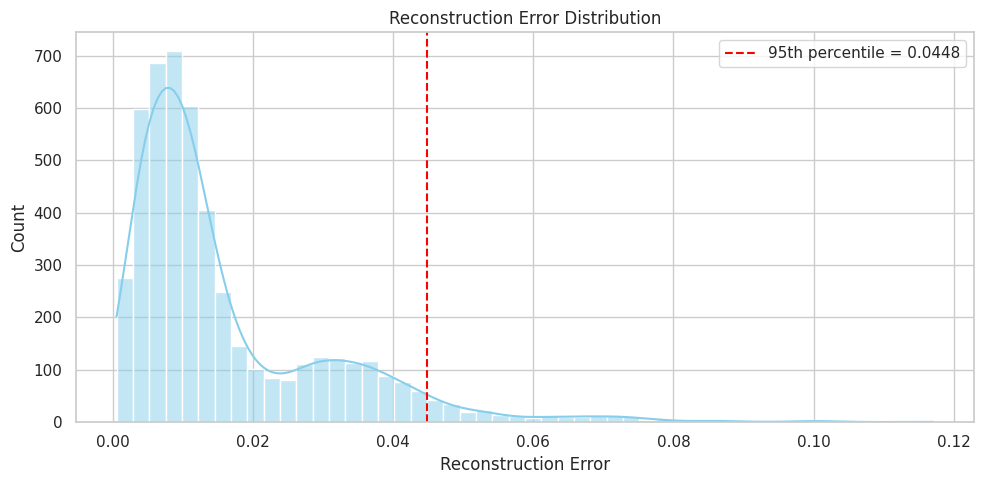


KMeans Silhouette Score: 0.2106

[KMeans] Cluster Counts:
  Cluster 0: 2013 samples
  Cluster 1: 1473 samples
  Cluster 2: 1514 samples

Agglomerative Silhouette Score: 0.1686

[Agglomerative] Cluster Counts:
  Cluster 0: 1385 samples
  Cluster 1: 1855 samples
  Cluster 2: 1760 samples

GMM Silhouette Score: 0.1418

[GMM] Cluster Counts:
  Cluster 0: 1631 samples
  Cluster 1: 1464 samples
  Cluster 2: 1905 samples


<ipython-input-2-54481bffcf3a>:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f"Cluster {i}" for i in counts.index], y=counts.values,


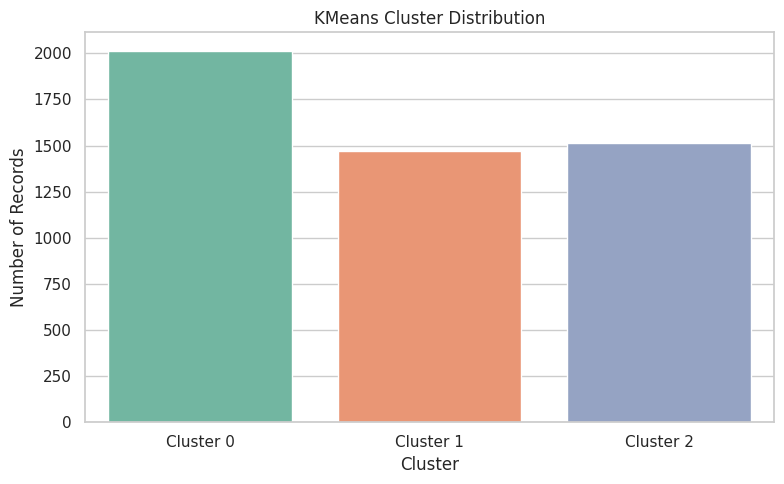

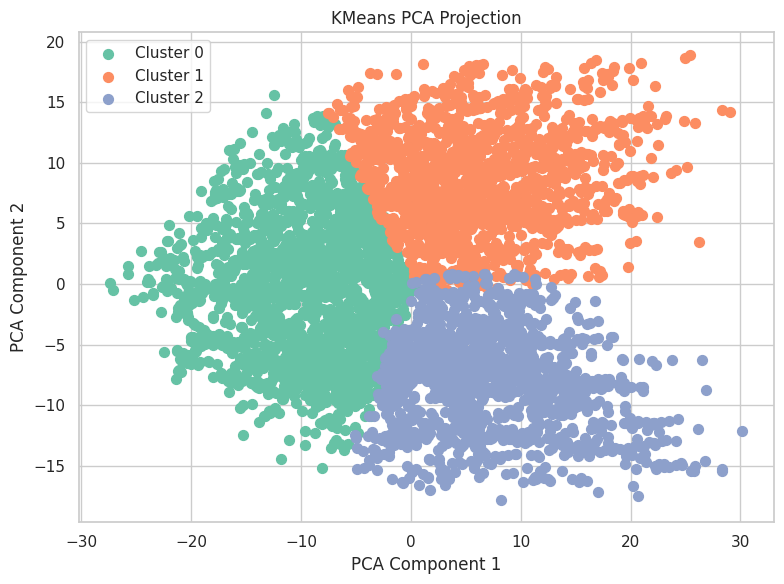

<ipython-input-2-54481bffcf3a>:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f"Cluster {i}" for i in counts.index], y=counts.values,


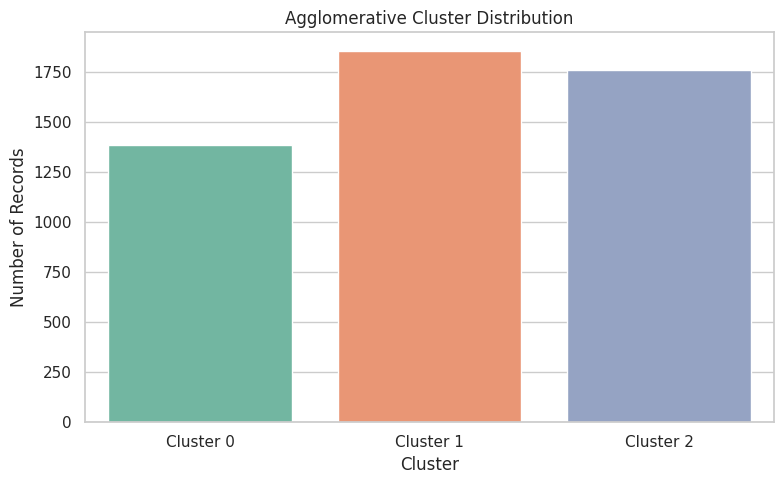

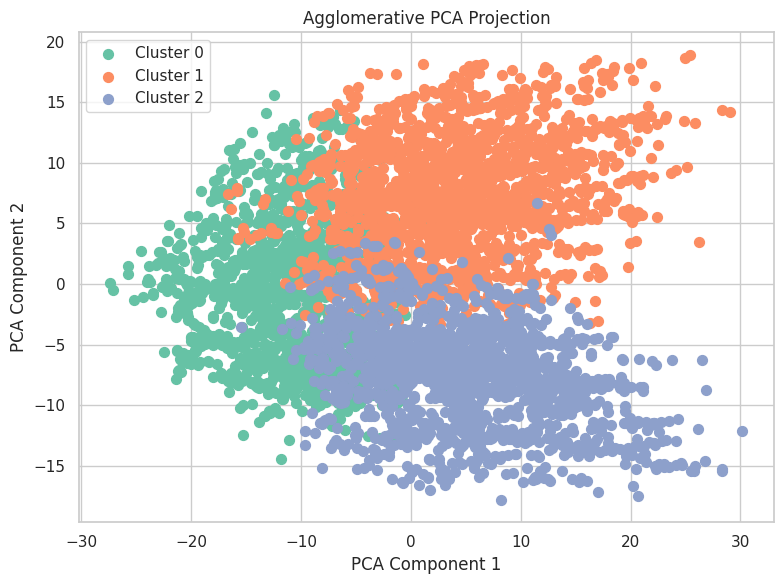

<ipython-input-2-54481bffcf3a>:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f"Cluster {i}" for i in counts.index], y=counts.values,


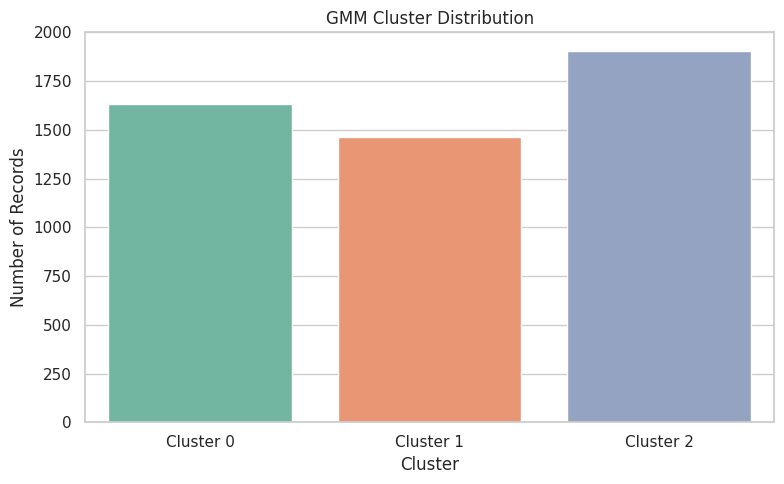

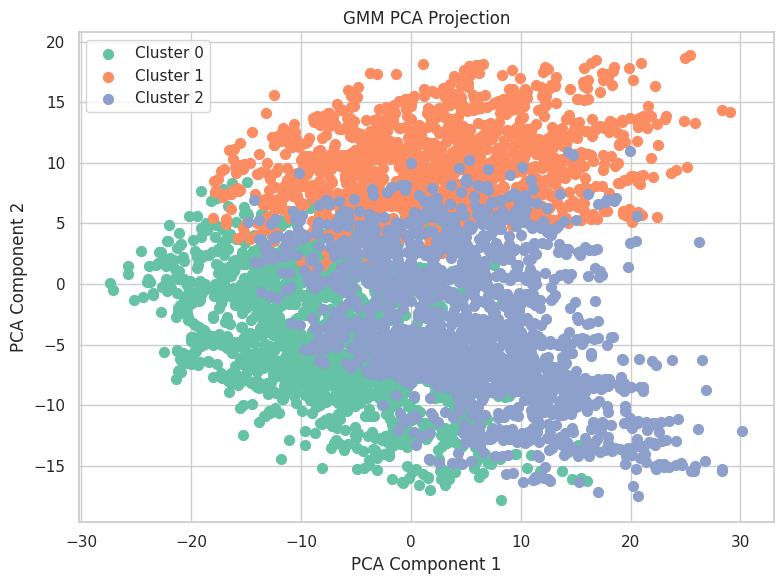


[✓] All clustering results and aligned labels saved to 'ransomware_all_cluster_results.csv'


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, pairwise_distances_argmin_min

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers


sns.set(style='whitegrid')


#  Load and Preprocess Data

df = pd.read_csv('Healthcare Ransomware Dataset.csv')
df.drop(columns=['id', 'attack_date'], inplace=True)

# Encode categorical
categorical_cols = df.select_dtypes(include='object').columns.tolist()
df_encoded = pd.get_dummies(df, columns=categorical_cols)

# Normalize
scaler = MinMaxScaler()
df_encoded[df_encoded.columns] = scaler.fit_transform(df_encoded)

X = df_encoded.astype('float32').values


#  Autoencoder
-
input_dim = X.shape[1]
input_layer = Input(shape=(input_dim,))
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
latent = Dense(8, activation='relu', name='latent_layer')(x)
x = Dense(16, activation='relu')(latent)
x = Dense(32, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(input_dim, activation='sigmoid')(x)

autoencoder = Model(inputs=input_layer, outputs=output)
autoencoder.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train
autoencoder.fit(X, X, epochs=150, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
encoder = Model(inputs=input_layer, outputs=latent)
encoded_data = encoder.predict(X)


#  Reconstruction Error

X_pred = autoencoder.predict(X)
reconstruction_errors = np.mean(np.square(X - X_pred), axis=1)
thresh = np.percentile(reconstruction_errors, 95)
print(f"[✓] Reconstruction threshold (95th percentile): {thresh:.4f}")

plt.figure(figsize=(10, 5))
sns.histplot(reconstruction_errors, bins=50, kde=True, color='skyblue')
plt.axvline(thresh, color='red', linestyle='--', label=f'95th percentile = {thresh:.4f}')
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# PCA for 2D Projection
# -------------------------------
pca = PCA(n_components=2)
reduced = pca.fit_transform(encoded_data)

# -------------------------------
# Label Alignment Helpers
# -------------------------------
def map_clusters(reference_centroids, target_centroids):
    mapping = pairwise_distances_argmin_min(target_centroids, reference_centroids)[0]
    return {i: mapping[i] for i in range(len(mapping))}

def run_and_remap_clustering(algorithm, name, encoded_data, reference_labels=None):
    if name == 'GMM':
        labels = algorithm.fit_predict(encoded_data)
        centers = algorithm.means_
    else:
        labels = algorithm.fit_predict(encoded_data)
        centers = np.array([encoded_data[labels == i].mean(axis=0) for i in np.unique(labels)])

    if reference_labels is None:
        return labels, centers
    else:
        reference_centers = np.array([encoded_data[reference_labels == i].mean(axis=0) for i in range(3)])
        remap = map_clusters(reference_centers, centers)
        labels = np.vectorize(remap.get)(labels)
        return labels, centers

# Define a fixed color palette
color_palette = {0: '#66c2a5', 1: '#fc8d62', 2: '#8da0cb'}

def plot_pca_scatter(reduced_data, labels, title):
    plt.figure(figsize=(8, 6))
    for cluster in sorted(np.unique(labels)):
        plt.scatter(
            reduced_data[labels == cluster, 0],
            reduced_data[labels == cluster, 1],
            label=f'Cluster {cluster}',
            s=50,
            color=color_palette[cluster]
        )
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_cluster_distribution(labels, title):
    counts = pd.Series(labels).value_counts().sort_index()
    plt.figure(figsize=(8, 5))
    sns.barplot(x=[f"Cluster {i}" for i in counts.index], y=counts.values,
                palette=[color_palette[i] for i in counts.index])
    plt.title(title)
    plt.xlabel("Cluster")
    plt.ylabel("Number of Records")
    plt.tight_layout()
    plt.show()


#  Apply Clustering
# -------------------------------
def print_cluster_info(labels, method_name):
    counts = pd.Series(labels).value_counts().sort_index()
    print(f"\n[{method_name}] Cluster Counts:")
    for i in counts.index:
        print(f"  Cluster {i}: {counts[i]} samples")

# KMeans (reference)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels, kmeans_centers = run_and_remap_clustering(kmeans, 'KMeans', encoded_data)
sil_kmeans = silhouette_score(encoded_data, kmeans_labels)
print(f"\nKMeans Silhouette Score: {sil_kmeans:.4f}")
print_cluster_info(kmeans_labels, "KMeans")

# Agglomerative
agglo = AgglomerativeClustering(n_clusters=3, linkage='ward')
agglo_labels, _ = run_and_remap_clustering(agglo, 'Agglomerative', encoded_data, reference_labels=kmeans_labels)
sil_agglo = silhouette_score(encoded_data, agglo_labels)
print(f"\nAgglomerative Silhouette Score: {sil_agglo:.4f}")
print_cluster_info(agglo_labels, "Agglomerative")

# GMM
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm_labels, _ = run_and_remap_clustering(gmm, 'GMM', encoded_data, reference_labels=kmeans_labels)
sil_gmm = silhouette_score(encoded_data, gmm_labels)
print(f"\nGMM Silhouette Score: {sil_gmm:.4f}")
print_cluster_info(gmm_labels, "GMM")

# -------------------------------
# Visualizations
# -------------------------------
plot_cluster_distribution(kmeans_labels, "KMeans Cluster Distribution")
plot_pca_scatter(reduced, kmeans_labels, "KMeans PCA Projection")

plot_cluster_distribution(agglo_labels, "Agglomerative Cluster Distribution")
plot_pca_scatter(reduced, agglo_labels, "Agglomerative PCA Projection")

plot_cluster_distribution(gmm_labels, "GMM Cluster Distribution")
plot_pca_scatter(reduced, gmm_labels, "GMM PCA Projection")

# -------------------------------
#  Save Output
# -------------------------------
df_results = df.copy()
df_results['cluster_kmeans'] = kmeans_labels
df_results['cluster_agglo'] = agglo_labels
df_results['cluster_gmm'] = gmm_labels

df_results.to_csv('ransomware_all_cluster_results.csv', index=False)
print("\n[✓] All clustering results and aligned labels saved to 'ransomware_all_cluster_results.csv'")